# Analyse légère pic simple

Le bloc de code ci-dessous permet d'installer les modules requis à l'analyse.

In [8]:
# ! python.exe -m pip install --upgrade pip
# ! pip install -r requirements.txt

In [9]:
from outils_analyse.identification_des_pics import determiner_indexes_maximums_scipy
from outils_analyse.lecture_des_fichiers import lire_csv_a_3_colonnes, crop_pour_conserver_que_la_partie_avec_rampe
from outils_analyse.conversion_temps_en_potentiel import \
    calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe
import matplotlib.pyplot as plt
import os
import matplotlib
import numpy as np
from sigfig import round
# Grosseur du text dans les figures
matplotlib.rcParams.update({'font.size': 18})
# Couleur des graphiques
import seaborn as sns
palette = sns.color_palette("muted")
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

## Lire le fichier des résultats et transformer les valeurs en un array numpy


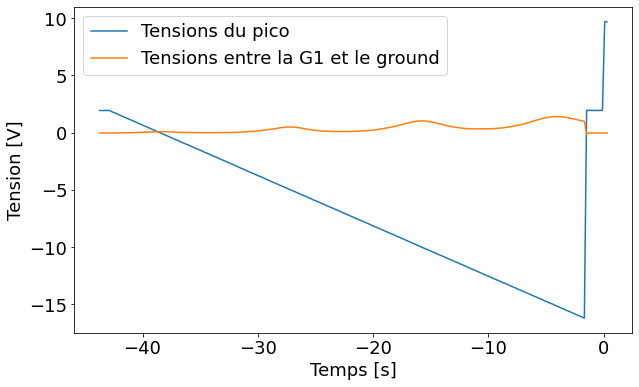

In [10]:
file_name = os.path.join("exemples_de_fichiers","exemple_de_donnees.csv")
valeurs_en_array = lire_csv_a_3_colonnes(file_name, 9)

plt.figure(figsize=(10,6))
plt.plot(valeurs_en_array[:, 0], valeurs_en_array[:, 2],
        label="Tensions du pico")
plt.plot(valeurs_en_array[:, 0], valeurs_en_array[:, 1],
        label="Tensions entre la G1 et le ground")
plt.xlabel("Temps [s]")
plt.ylabel("Tension [V]")
plt.legend()
plt.show()

## Retirer les valeurs qui se trouvent à l'extérieur de l'activation du générateur de rampe
> Modifier `zero_threshold` et `infinity_threshold` au besoin

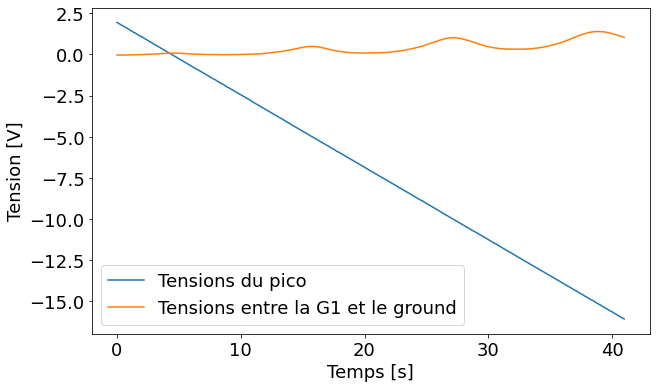

In [14]:
valeurs_cropped_debutant_par_t0 = crop_pour_conserver_que_la_partie_avec_rampe(valeurs_en_array,
        indice_colonne_rampe=2, zero_threshold=0.04, infinity_threshold=0.1)

debut = min(valeurs_cropped_debutant_par_t0[:,0])
valeurs_cropped_debutant_par_t0[:,0]-=debut

plt.figure(figsize=(10,6))
plt.plot(valeurs_cropped_debutant_par_t0[:, 0], valeurs_cropped_debutant_par_t0[:, 2],
         label="Tensions du pico")
plt.plot(valeurs_cropped_debutant_par_t0[:, 0], valeurs_cropped_debutant_par_t0[:, 1],
         label="Tensions entre la G1 et le ground")
plt.xlabel("Temps [s]")
plt.ylabel("Tension [V]")
plt.legend()
plt.show()

## Pente de la tension du générateur de rampe + Tensions du pico en courant 

Pente = -0.44 ± 0.03 [V/s]


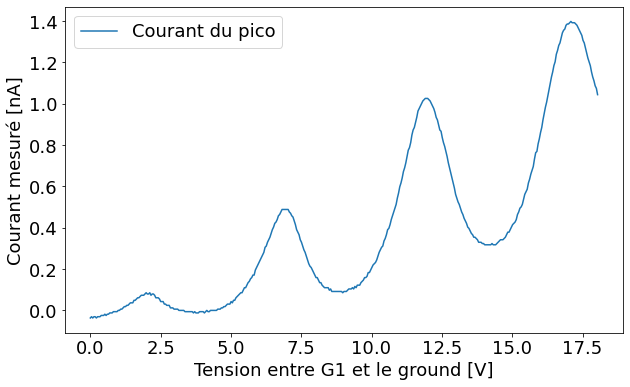

In [15]:
facteur_conversion_temps_en_potentiel = calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe(
    valeurs_cropped_debutant_par_t0, indice_colonne_temps=0, indice_colonne_rampe=2)
facteur_valeur = facteur_conversion_temps_en_potentiel[0]
facteur_incertitude = facteur_conversion_temps_en_potentiel[1]
print(f"Pente = {round(facteur_valeur, facteur_incertitude)} [V/s]")

valeurs_avec_bonnes_unites = valeurs_cropped_debutant_par_t0.copy()
valeurs_avec_bonnes_unites[:, 0] = -facteur_conversion_temps_en_potentiel[0] * valeurs_cropped_debutant_par_t0[:, 0] 

plt.figure(figsize=(10,6))
plt.plot(valeurs_avec_bonnes_unites[:, 0], valeurs_avec_bonnes_unites[:, 1],
         label="Courant du pico")
plt.xlabel("Tension entre G1 et le ground [V]")
plt.ylabel("Courant mesuré [nA]")
plt.legend()
plt.show()

## Déterminer l'emplacement approximatif des maximums
> Modifier `distance_minimum` au besoin

Estimation des pics : [ 1.9844797  6.902538  11.950019  17.083782 ] [V]
Écart moyen entre chaque pic (V_{res}) : 5.03 ± 0.09 [V]
Potentiel de contact (W) : 0.951 [V]


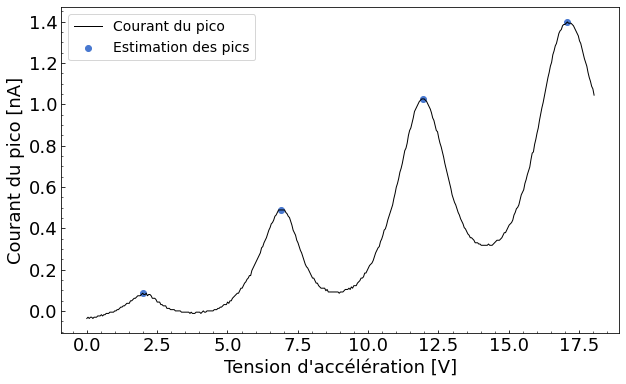

In [13]:
liste_des_indexes_des_pics = determiner_indexes_maximums_scipy(valeurs_avec_bonnes_unites,
        colonne_y=1, distance_minimum=100)
ecarts = np.diff(valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0])
ecart_std = np.std(ecarts)
ecart_moyen = np.mean(ecarts)
tension_u1 = 4.0
tension_u2 = valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0][0]
potentiel_contact = tension_u1 + tension_u2 - ecart_moyen

print(f"Estimation des pics : {valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0]} [V]")
print(f"Écart moyen entre chaque pic (V_{{res}}) : {round(ecart_moyen, ecart_std)} [V]")
print(f"Potentiel de contact (W) : {round(potentiel_contact, decimals=3)} [V]")

valeurs_avec_bonnes_unites_determination_des_pics = valeurs_avec_bonnes_unites

plt.figure(figsize=(10,6))
plt.plot(valeurs_avec_bonnes_unites_determination_des_pics[:, 0],
        valeurs_avec_bonnes_unites_determination_des_pics[:, 1],
        label="Courant du pico", color="black", linewidth=1)
plt.scatter(valeurs_avec_bonnes_unites_determination_des_pics[liste_des_indexes_des_pics, 0],
        valeurs_avec_bonnes_unites_determination_des_pics[liste_des_indexes_des_pics, 1],
        label="Estimation des pics", color=palette[0])
plt.xlabel("Tension d'accélération [V]")
plt.ylabel("Courant du pico [nA]")
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='both', direction='in')
plt.minorticks_on()
plt.show()

# Ref - Estimation des pics: [ 1.9844797  6.902538  11.950019  17.083782 ] [V]